In [1]:
#
# Valuation of European call options in Black-Scholes-Merton model
# 

# Analytical Black-Scholes-Merton(BSM) Formula

In [2]:
%%latex
\begin{align}
C(S_{t}, K_{t},T,r,\sigma) = S_{t} \cdot N(d_{1}) -e^{-r(T-t)} \cdot K \cdot N(d_{2}) \\
N(d) = \frac{1}{\sqrt{2\pi}}\int_{-∞}^{d} e^{-\frac{1}{2}x^{2}}dx \\
d_{1} = \frac{\log\frac{S_{t}}{K}+(r+\frac{\sigma^{2}}{2})(T-t)}{\sigma\sqrt{T-t}} \\
d_{2} = \frac{\log\frac{S_{t}}{K}+(r-\frac{\sigma^{2}}{2})(T-t)}{\sigma\sqrt{T-t}}
\end{align}

<IPython.core.display.Latex object>

In [3]:
import math
import scipy.stats

In [4]:
def bsm_call_value(S0, K, T, R, sigma):
    """Valuation of European call option in BSM model Analytical formula
        
    Parameters
    - S0 : float(initial stock/index level)
    - K : float(strike price)
    - T : float(maturity date : in year fractions)
    - r : float(constant risk-free short rate)
    - sigma : float(volatility factor in diffusion term)
    
    Returns
    - value : float(present value of the European call option)
    """
    
    SO = float(S0)
    d1 = ( (math.log(S0) / K) + (r + 0.5 * sigma ** 2) * T ) / (sigma * math.sqrt(T) )
    d2 = ( (math.log(S0) / K) + (r - 0.5 * sigma ** 2) * T ) / (sigma * math.sqrt(T) )
    value = ( S0 * scipy.stats.norm.cdf(d1, 0.0, 1.0) - K * math.exp(-r * T) * scipy.stats.norm.cdf(d2, 0.0, 1.0))
    # scipy.stats.norm.cdf : cumulative distribution function for normal distribution
    return value

In [5]:
def bsm_vega(S0, K, T, r, sigma):
    """Vega of European option in BSM model
    
    Parameters
    - S0 : float(initial stock/index level)
    - K : float(strike price)
    - T : float(maturity date : in year fractions)
    - r : float(constant risk-free short rate)
    - sigma : float(volatility factor in diffusion term)
    
    Returns
    - vega : float(partial derivative of BSM formula with respect to sigma, i.e. Vega)
    
    """
    
    SO = float(S0)
    d1 = ( (math.log(S0) / K) + (r + 0.5 * sigma ** 2) * T ) / (sigma * math.sqrt(T) )
    vega = S0 * scipy.stats.norm.cdf(d1, 0.0, 1.0) * math.sqrt(T)
    
    return vega   
    

In [6]:
def bsm_call_imp_vol(S0, K, T, r, C0, sigma_est, it=100):
    """Implied volatility of European call option in BSM model
    
    Parameters
    - SO : float(initial stock/intex level)
    - K : float(strike price)
    - T : float(maturity date : in year fractions)
    - r : float(constant risk-free short rate)
    - sigma_est : float(estimate of impl. volatility)
    - it : integer(number of iterations)
    
    Returns
    - sigma_est : float(numberically estimated implied volatility)
    """
    
    for index in range(it):
        sigma_est -= ((bsm_call_value(S0, K, T, r, sigma_est) - C0) / bsm_vega(S0, K, T, r, sigma_est))
        
    return sigma_est
    
    

In [7]:
V0 = 17.6639

In [8]:
r = 0.01

In [9]:
import pandas as pd
h5 = pd.HDFStore('./vstoxx_data_31032014.h5', 'r')
futures_data = h5['futures_data']
options_data = h5['options_data']
h5.close()

In [10]:
options_data['DATE'] = pd.to_datetime(options_data.DATE)
futures_data['DATE'] = pd.to_datetime(futures_data.DATE)
options_data['MATURITY'] = pd.to_datetime(options_data.MATURITY)
futures_data['MATURITY'] = pd.to_datetime(futures_data.MATURITY)

In [11]:
options_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395 entries, 46170 to 46564
Data columns (total 8 columns):
DATE         395 non-null datetime64[ns]
EXP_YEAR     395 non-null int64
EXP_MONTH    395 non-null int64
TYPE         395 non-null object
STRIKE       395 non-null float64
PRICE        395 non-null float64
MATURITY     395 non-null datetime64[ns]
TTM          395 non-null float64
dtypes: datetime64[ns](2), float64(3), int64(2), object(1)
memory usage: 27.8+ KB


In [12]:
options_data[['DATE', 'MATURITY', 'TTM', 'STRIKE', 'PRICE']].head()

,DATE,MATURITY,TTM,STRIKE,PRICE
46170,2014-03-31,2014-04-18,0.049,1.0,16.85
46171,2014-03-31,2014-04-18,0.049,2.0,15.85
46172,2014-03-31,2014-04-18,0.049,3.0,14.85
46173,2014-03-31,2014-04-18,0.049,4.0,13.85
46174,2014-03-31,2014-04-18,0.049,5.0,12.85


In [13]:
options_data['IMP_VOL'] = 0.0

In [14]:
to1 = 0.5

for option in options_data.index:
    forward = futures_data[futures_data['MATURITY'] == \
                           options_data.loc[option]['MATURITY']]['PRICE'].values[0]
    if forward * (1-to1) < options_data.loc[option]['STRIKE'] < forward * (1 + to1):
        imp_vol = bsm_call_imp_vol(
            V0,
            options_data.loc[option]['STRIKE'],
            options_data.loc[option]['TTM'],
            r,
            options_data.loc[option]['PRICE'],
            sigma_est = 2.,
            it = 100
        )
        options_data['IMP_VOL'].loc[option] = imp_vol
                           

/Users/hknam/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [15]:
futures_data['MATURITY']

496   2014-04-18
497   2014-05-16
498   2014-06-20
499   2014-07-18
500   2014-08-15
501   2014-09-19
502   2014-10-17
503   2014-11-21
Name: MATURITY, dtype: datetime64[ns]

In [16]:
options_data.loc[46170]

DATE         2014-03-31 00:00:00
EXP_YEAR                    2014
EXP_MONTH                      4
TYPE                           C
STRIKE                         1
PRICE                      16.85
MATURITY     2014-04-18 00:00:00
TTM                        0.049
IMP_VOL                        0
Name: 46170, dtype: object

In [17]:
options_data.loc[46170]['STRIKE']

1.0

In [18]:
plot_data = options_data[options_data['IMP_VOL'] > 0]

In [19]:
maturities = sorted(set(options_data['MATURITY']))
maturities

[Timestamp('2014-04-18 00:00:00'),
 Timestamp('2014-05-16 00:00:00'),
 Timestamp('2014-06-20 00:00:00'),
 Timestamp('2014-07-18 00:00:00'),
 Timestamp('2014-08-15 00:00:00'),
 Timestamp('2014-09-19 00:00:00'),
 Timestamp('2014-10-17 00:00:00'),
 Timestamp('2014-11-21 00:00:00')]

/Users/hknam/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


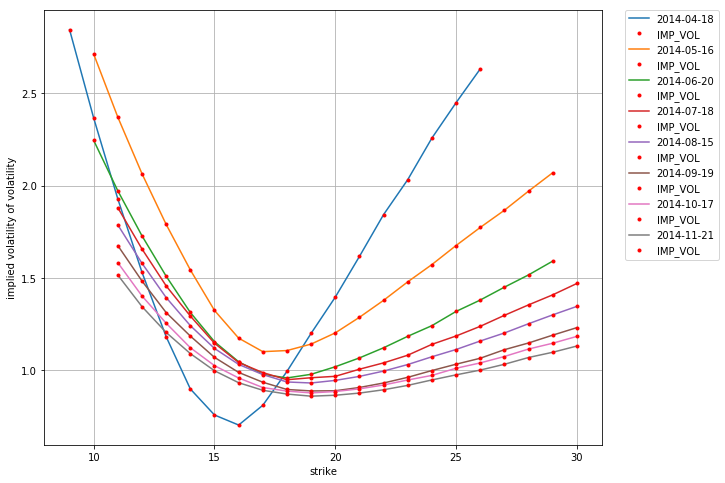

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,8))
for maturity in maturities:
    data = plot_data[options_data.MATURITY == maturity]
    plt.plot(data['STRIKE'], data['IMP_VOL'],
            label=maturity.date(), lw=1.5)
    
    plt.plot(data['STRIKE'], data['IMP_VOL'], 'r.')
    
plt.grid(True)
plt.xlabel('strike')
plt.ylabel('implied volatility of volatility')
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)
plt.show()